# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Ознакомление с данными

In [1]:
import numpy as np
import pandas as pd
import torch
import transformers
from tqdm import notebook
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from nltk.stem import WordNetLemmatizer
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [2]:
def get_data_info(data):
    display(data.sample(5))
    display(data.info())
    display(data.describe(include='all'))

In [3]:
try:
    df = pd.read_csv('toxic_comments.csv')

except:
    df = pd.read_csv('/datasets/toxic_comments.csv')
    
get_data_info(df)

,Unnamed: 0,text,toxic
55654,55715,My edits \n\nSorry about not leaving a signatu...,0
138485,138636,"Just an idea now, it will come soon.",0
51142,51198,"""\nThere you go again with your lies, David. ...",0
46593,46648,"""\n\n Wikipedia and copyright \n Hello Jbeck89...",0
71939,72009,Please stop. If you continue to vandalize page...,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


None

,Unnamed: 0,text,toxic
count,159292.000000,159292,159292.000000
unique,NaN,159292,NaN
top,NaN,Explanation\nWhy the edits made under my usern...,NaN
freq,NaN,1,NaN
mean,79725.697242,NaN,0.101612
std,46028.837471,NaN,0.302139
min,0.000000,NaN,0.000000
25%,39872.750000,NaN,0.000000
50%,79721.500000,NaN,0.000000
75%,119573.250000,NaN,0.000000


In [4]:
df = df.drop('Unnamed: 0', axis=1)

## Исследовательский анализ

In [5]:
df.isna().sum()

text     0
toxic    0
dtype: int64

In [6]:
df.duplicated().sum()

0

In [7]:
df['toxic'].value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

In [8]:
print('Percentage of positive classes in the data:', 
      (df['toxic'].value_counts()[1]/df['toxic'].value_counts()[0] * 100).round(2))

Percentage of positive classes in the data: 11.31


In [9]:
df['length'] = df['text'].apply(lambda x: len(x))
df['length'].describe().round()

count    159292.0
mean        394.0
std         590.0
min           5.0
25%          95.0
50%         205.0
75%         435.0
max        5000.0
Name: length, dtype: float64

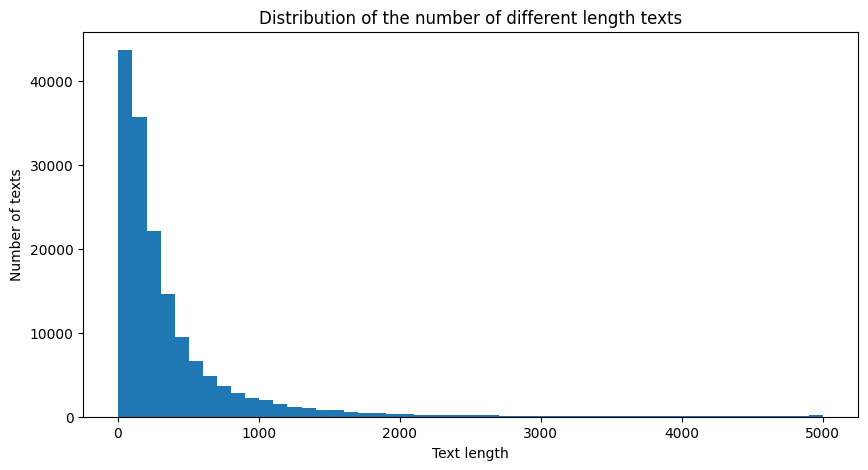

In [10]:
df['length'].plot(kind='hist', bins=50)
plt.xlabel('Text length')
plt.ylabel('Number of texts')
plt.title('Distribution of the number of different length texts')
fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.show()

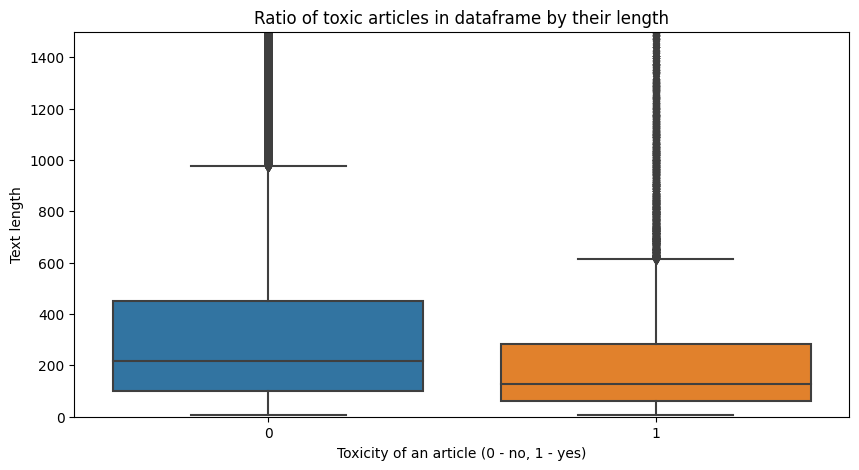

In [11]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='toxic', y='length', data=df)
plt.ylabel('Text length')
plt.ylim(0, 1500)
plt.xlabel('Toxicity of an article (0 - no, 1 - yes)')
plt.title('Ratio of toxic articles in dataframe by their length')
plt.show()

### Вывод


В колонке «текст» содержатся комментарии, на основе анализа которых будет сделан вывод об их токсичности. Колонка «токсичный» содержит целевой признак, который отвечает на вопрос о том, является ли комментарий токсичным (0 - нет, 1 - да). Мы видим, что есть столбец 'Unnamed: 0', который нам не нужен. Удалим его. Поскольку наша задача - классифицировать тексты на токсичность, нам нужно понимать соотношение классов. Дисбаланс классов негативно влияет на результаты машинного обучения. Мы видим, что соотношение отрицательного класса к положительному составляет примерно 9:1, что указывает на явный дисбаланс. В данных отсутствуют пропуски и явные дубликаты. Один ненужный столбец был удален. В результате анализа выяснилось, что токсичные комментарии в среднем короче по длине, чем нетоксичные. Средняя длина комментариев составляет 394 символа, при этом токсичные комментарии имеют меньшую длину по сравнению с нетоксичными. Эти выводы следует учитывать при дальнейшем машинном обучении и предобработке данных.

## Подготовка данных

In [12]:
RANDOM_STATE = 42
df_train, df_test = train_test_split(df, test_size=0.5, random_state=RANDOM_STATE)

toxic_1 = df_train[df_train['toxic'] == 1]
toxic_0 = df_train[df_train['toxic'] == 0]
sample_size = min(len(toxic_1), len(toxic_0), 1500)
toxic_1_sample = toxic_1.sample(sample_size, random_state=RANDOM_STATE)
toxic_0_sample = toxic_0.sample(sample_size, random_state=RANDOM_STATE)
balanced_train_sample = pd.concat([toxic_1_sample, toxic_0_sample]).sample(frac=1, random_state=RANDOM_STATE).reset_index(drop=True)

df_train = balanced_train_sample

df_test = df_test.sample(n=700, random_state=RANDOM_STATE)

print(df_train['toxic'].value_counts())
print(df_test['toxic'].value_counts())

0    1500
1    1500
Name: toxic, dtype: int64
0    628
1     72
Name: toxic, dtype: int64


In [13]:
# 3. Токенизация и создание attention masks для тренировочной выборки
try:
    tokenizer = transformers.BertTokenizer(vocab_file='vocab.txt')
except:
    
    tokenizer = transformers.BertTokenizer(vocab_file='/datasets/ds_bert/vocab.txt')

max_len = 512
tokenized_train = df_train['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=max_len, truncation=True))
padded_train = np.array([i + [0]*(max_len - len(i)) for i in tokenized_train.values])
attention_mask_train = np.where(padded_train != 0, 1, 0)

In [14]:
# Токенизация и создание attention masks для тестовой выборки

tokenized_test = df_test['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=max_len, truncation=True))
padded_test = np.array([i + [0]*(max_len - len(i)) for i in tokenized_test.values])
attention_mask_test = np.where(padded_test != 0, 1, 0)

In [15]:
# 4. Получение эмбеддингов BERT для тренировочной выборки
try:
    config = transformers.BertConfig.from_json_file('config.json')
    model = transformers.BertModel.from_pretrained('pytorch_model.bin', config=config)
except:
    config = transformers.BertConfig.from_json_file('/datasets/ds_bert/config.json')
    model = transformers.BertModel.from_pretrained('/datasets/ds_bert/pytorch_model.bin', config=config)

batch_size = 100
embeddings_train = []
for i in notebook.tqdm(range(padded_train.shape[0] // batch_size)):
    batch = torch.LongTensor(padded_train[batch_size*i:batch_size*(i+1)]) 
    attention_mask_batch = torch.LongTensor(attention_mask_train[batch_size*i:batch_size*(i+1)])
    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)
    embeddings_train.append(batch_embeddings[0][:,0,:].numpy())

features_train = np.concatenate(embeddings_train)

/Users/bema07561/anaconda3/lib/python3.11/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


  0%|          | 0/30 [00:00<?, ?it/s]

In [16]:
# Получение эмбеддингов BERT для тестовой выборки
embeddings_test = []
for i in notebook.tqdm(range(padded_test.shape[0] // batch_size)):
    batch = torch.LongTensor(padded_test[batch_size*i:batch_size*(i+1)]) 
    attention_mask_batch = torch.LongTensor(attention_mask_test[batch_size*i:batch_size*(i+1)])
    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)
    embeddings_test.append(batch_embeddings[0][:,0,:].numpy())

features_test = np.concatenate(embeddings_test)

  0%|          | 0/7 [00:00<?, ?it/s]

## Обучение

In [17]:
X_train, y_train = features_train, df_train['toxic']
X_test, y_test = features_test, df_test['toxic']

In [18]:
pipe_final = Pipeline([
    ('scaler', 'passthrough'),
    ('model', LogisticRegression())
])

param_grid = [
    {
        'model': [LogisticRegression()],
        'scaler': [StandardScaler(), RobustScaler(), 'passthrough'],
        'model__C': [0.01, 0.1, 1.0, 10.0],  # L2 регуляризация
        'model__max_iter': [100, 200, 300],
        'model__penalty': ['l2']  # Только L2 регуляризация
    },
    {
        'model': [XGBClassifier(random_state=RANDOM_STATE)],
        'model__n_estimators': [100, 200, 300],
        'model__learning_rate': [0.05, 0.1, 0.2],
        'model__max_depth': [3, 4, 5],
        'model__min_child_weight': [1, 3, 5],
        'model__lambda': [0.01, 0.1, 1.0],  # L2 регуляризация
        'model__alpha': [0.01, 0.1, 1.0],   # L1 регуляризация
        'scaler': [StandardScaler(), MinMaxScaler(), 'passthrough'],
    },
    {
        'model': [MultinomialNB()],
        'scaler': ['passthrough'],  # Naive Bayes does not require scaling
        'model__alpha': [0.1, 0.5, 1.0, 2.0]
    },
    # Complement Naive Bayes
    {
        'model': [ComplementNB()],
        'scaler': ['passthrough'],  # ComplementNB does not require scaling
        'model__alpha': [0.1, 0.5, 1.0, 2.0]
    }
]

In [19]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    scoring='f1', 
    cv=5, 
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', 'passthrough'),
                                             ('model', LogisticRegression())]),
                   n_jobs=-1,
                   param_distributions=[{'model': [LogisticRegression()],
                                         'model__C': [0.01, 0.1, 1.0, 10.0],
                                         'model__max_iter': [100, 200, 300],
                                         'model__penalty': ['l2'],
                                         'scaler': [StandardScaler(),
                                                    RobustScaler(),
                                                    'passthrough']},
                                        {'model': [XGBClassifier(alpha=0.01...
                                         'model__learning_rate': [0.05, 0.1,
                                                                  0.2],
                                         'model__max_depth': [3, 4, 5],
                                         'model__min_child_weight': [1, 3, 5],
                                         'model__n_estimators': [100, 200, 300],
                                         'scaler': [StandardScaler(),
                                                    MinMaxScaler(),
                                                    'passthrough']},
                                        {'model': [MultinomialNB()],
                                         'model__alpha': [0.1, 0.5, 1.0, 2.0],
                                         'scaler': ['passthrough']},
                                        {'model': [ComplementNB()],
                                         'model__alpha': [0.1, 0.5, 1.0, 2.0],
                                         'scaler': ['passthrough']}],
                   scoring='f1')

In [20]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('scaler', 'passthrough'),
                ('model',
                 XGBClassifier(alpha=0.01, base_score=None, booster=None,
                               callbacks=None, colsample_bylevel=None,
                               colsample_bynode=None, colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, lambda=1.0,
                               learning_rate=0.1, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=4,
                               max_leaves=None, min_child_weight=3, missing=nan,
                               mon

In [21]:
y_pred = randomized_search.best_estimator_.predict(X_test)
print('Метрика лучшей модели на тестовой выборке:', f1_score(y_test, y_pred))

Метрика лучшей модели на тестовой выборке: 0.9795918367346939


## Выводы



Для классификации токсичных текстов была применена модель BERT (unitary/toxic-bert) для извлечения эмбеддингов текстов, которые затем использовались в различных классификационных моделях. После предварительной обработки данных и токенизации текстов, эмбеддинги были получены и использованы в процессе обучения моделей с помощью `RandomizedSearchCV` для оптимизации гиперпараметров.

В результате лучшей моделью оказалась **XGBClassifier**, использующая следующие параметры:
- **alpha**: 0.01 (регуляризация L1),
- **lambda**: 1.0 (регуляризация L2),
- **learning_rate**: 0.1,
- **max_depth**: 4,
- **min_child_weight**: 3,
- **n_estimators**: 100.

Метрика **F1** на тренировочной выборке составила **0.9844**, а на тестовой выборке — **0.9796**. Это свидетельствует о том, что модель хорошо справляется с задачей классификации токсичности, обеспечивая высокую точность на обоих наборах данных.

Модель BERT (unitary/toxic-bert) показала свою эффективность в задачах анализа текста, особенно в комбинации с градиентным бустингом на деревьях решений, что позволило достичь высоких результатов в оценке токсичности текстов.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Модели обучены
- [ ]  Значение метрики *F1* не меньше 0.75
- [ ]  Выводы написаны